In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from scipy.integrate import cumulative_trapezoid
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter
import seaborn as sns

import sys
sys.path.append('../src')
import plotting, helpers
from importlib import reload

%config InlineBackend.figure_format = 'retina'


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7*fs,
          'legend.title_fontsize': 0.8*fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


In [2]:
binaries = cogsworth.pop.load("/mnt/ceph/users/twagg/underworld/binaries", parts=[])
sweeney = pd.read_hdf("/mnt/ceph/users/twagg/underworld/sweeney_remnants.h5", key="data")
sweeney["co_type"] = np.where(sweeney["mass"] < 25, 13, 14)

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


In [3]:
binaries.label = "Binaries"
binaries.colour = "#96B73B"
binaries.bpp["row_num"] = np.arange(len(binaries.bpp))

# Counts

In [4]:
print("Total binaries:", len(sweeney))
sweeney["co_type"].value_counts()

Total binaries: 186386


co_type
13    148428
14     37958
Name: count, dtype: int64

In [5]:
binary_co_types = np.concatenate((binaries.final_bpp["kstar_1"], binaries.final_bpp["kstar_2"]))
binary_co_types = binary_co_types[np.isin(binary_co_types, [13, 14])]
print("Total binaries:", len(binary_co_types))
pd.Series(binary_co_types).value_counts()

Total binaries: 200093


13    144806
14     55287
Name: count, dtype: int64

# Density comparison

In [6]:
kinematics = helpers.get_kinematics([binaries])
kinematics["Sweeney"] = {
    "pos": {},
    "vel": {}
}

for co_type_label, co_type in zip(["NS", "BH", "CO"], [[13], [14], [13, 14]]):
    mask = sweeney["co_type"].isin(co_type)
    kinematics["Sweeney"]["pos"][co_type_label] = sweeney[mask][["x_final", "y_final", "z_final"]].values * u.kpc
    kinematics["Sweeney"]["vel"][co_type_label] = sweeney[mask][["v_x_final", "v_y_final", "v_z_final"]].values * u.km/u.s

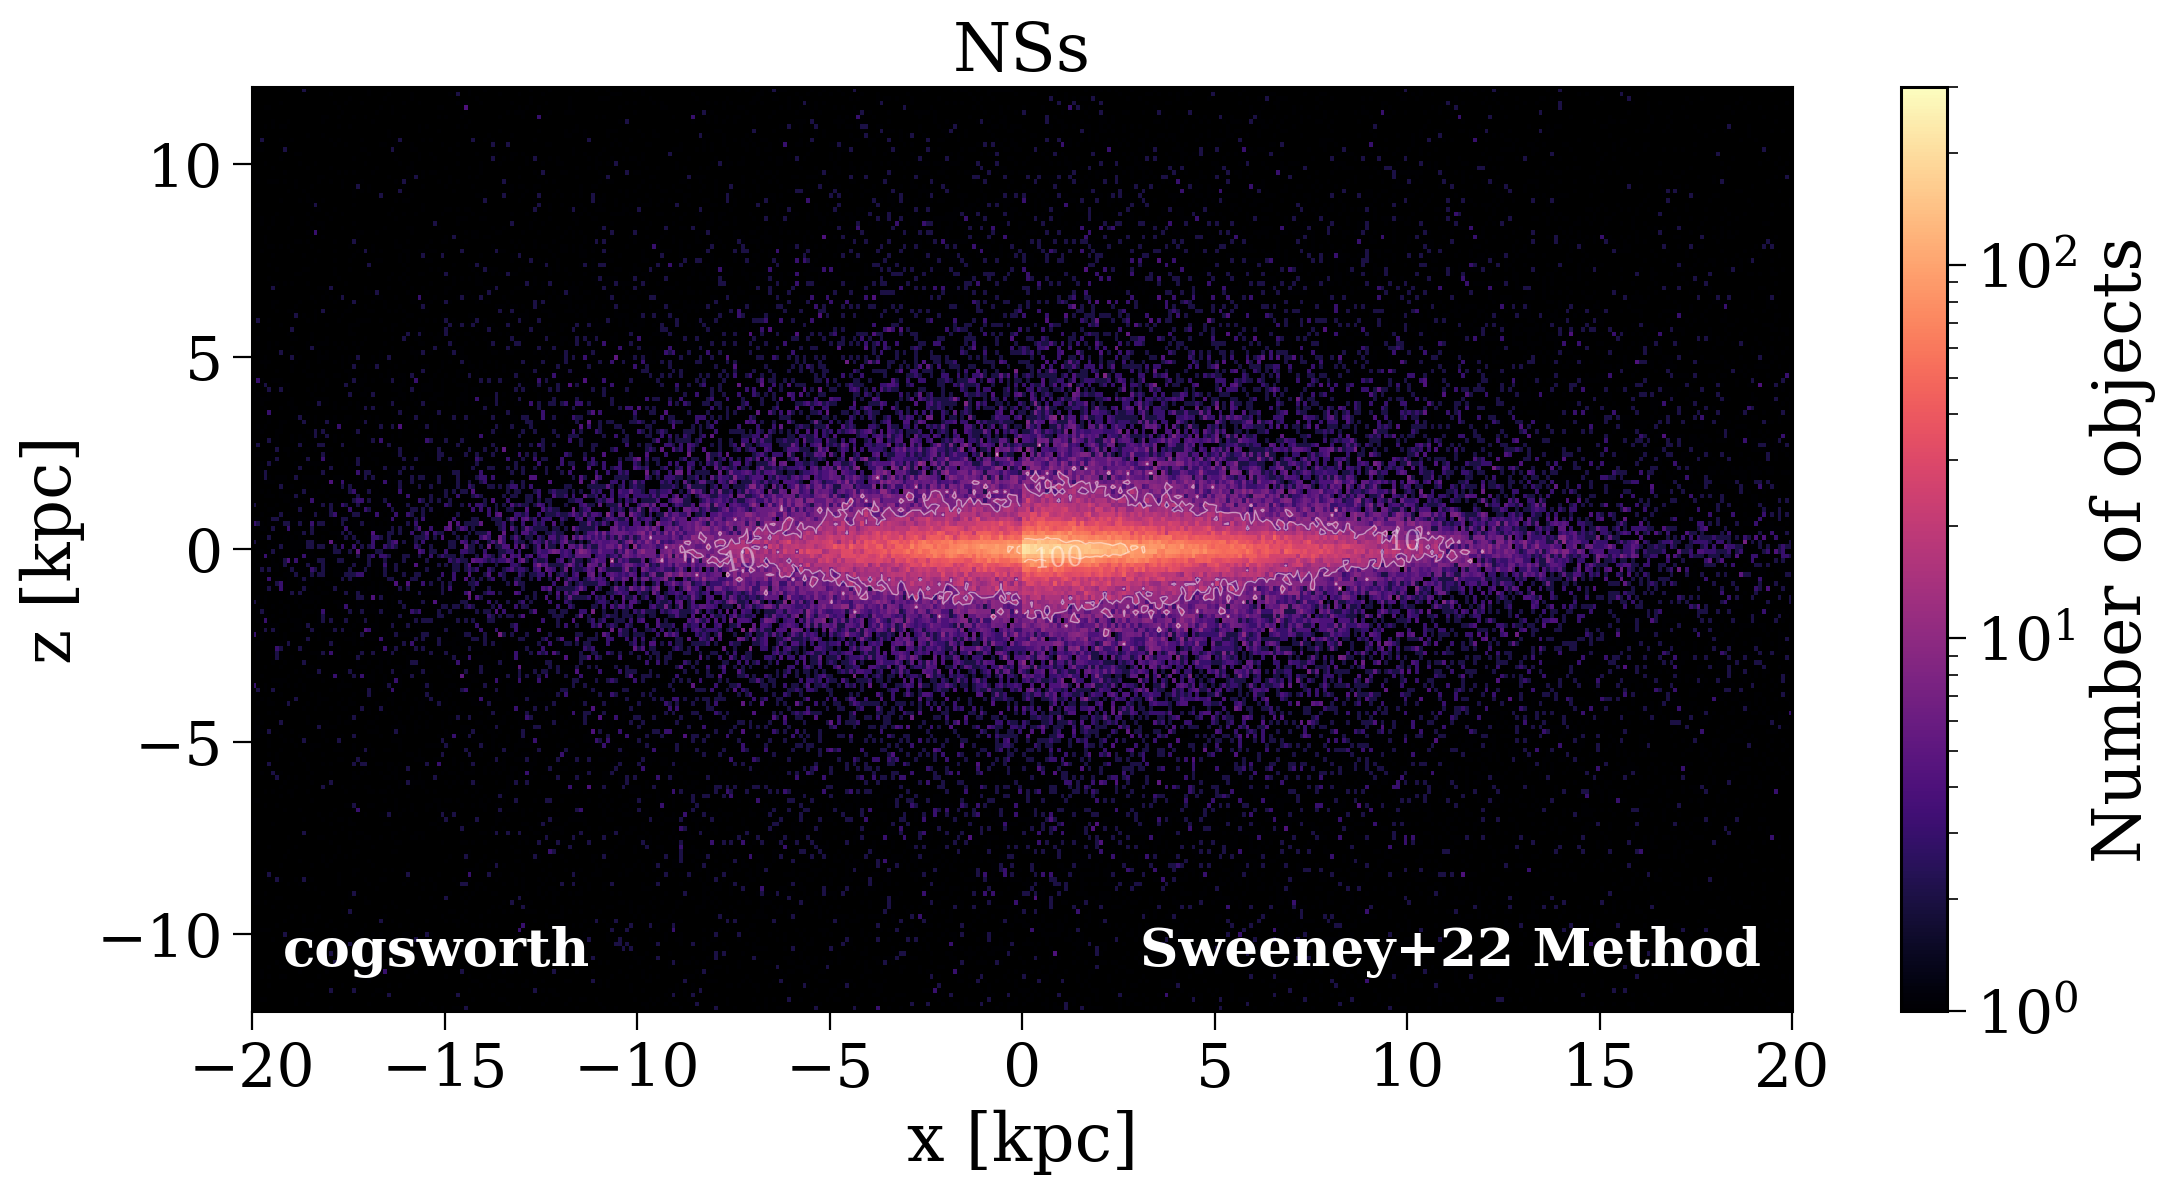

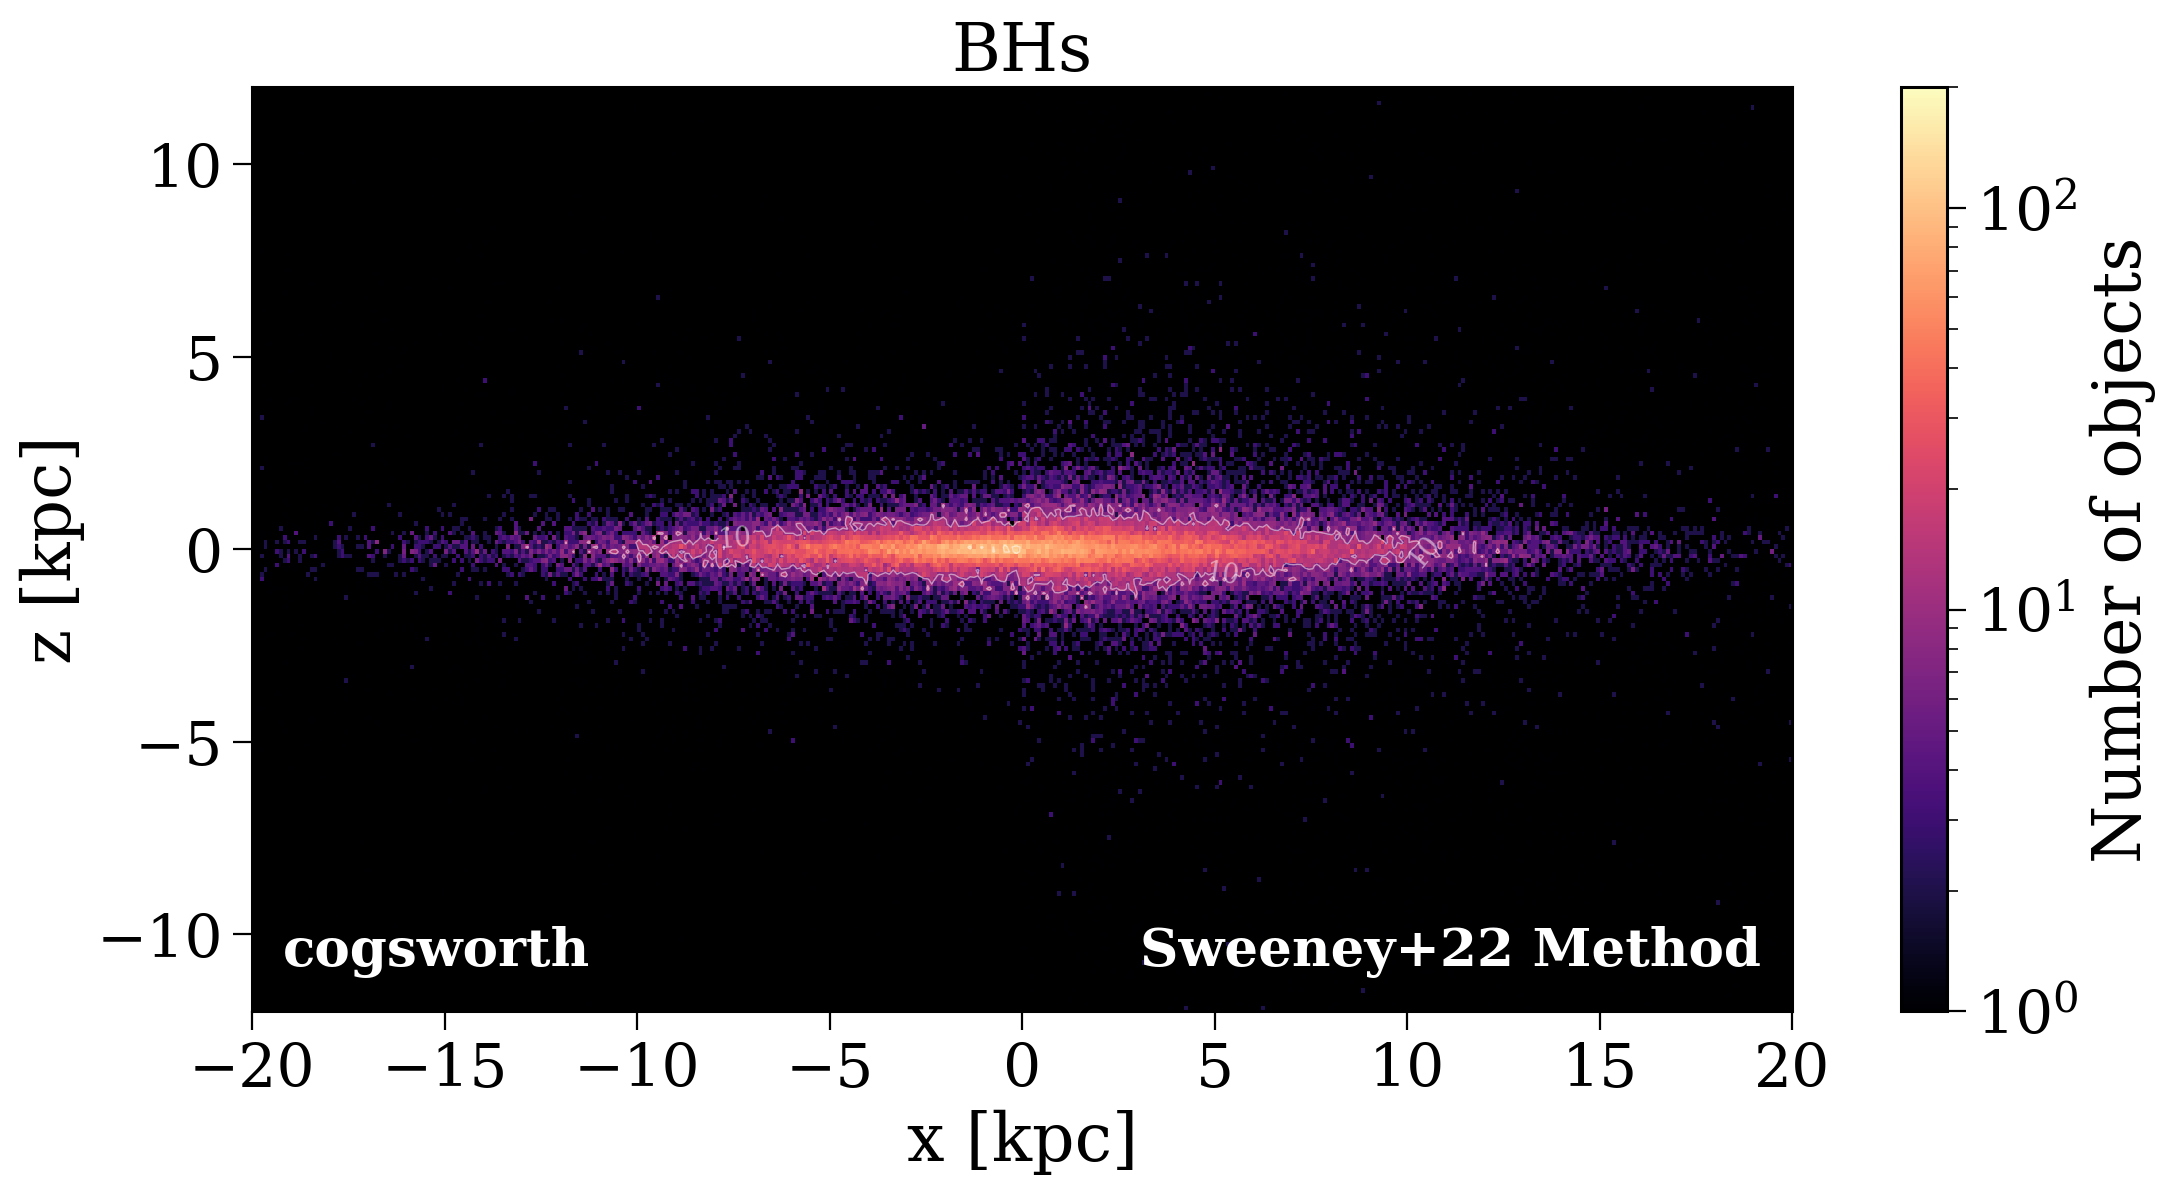

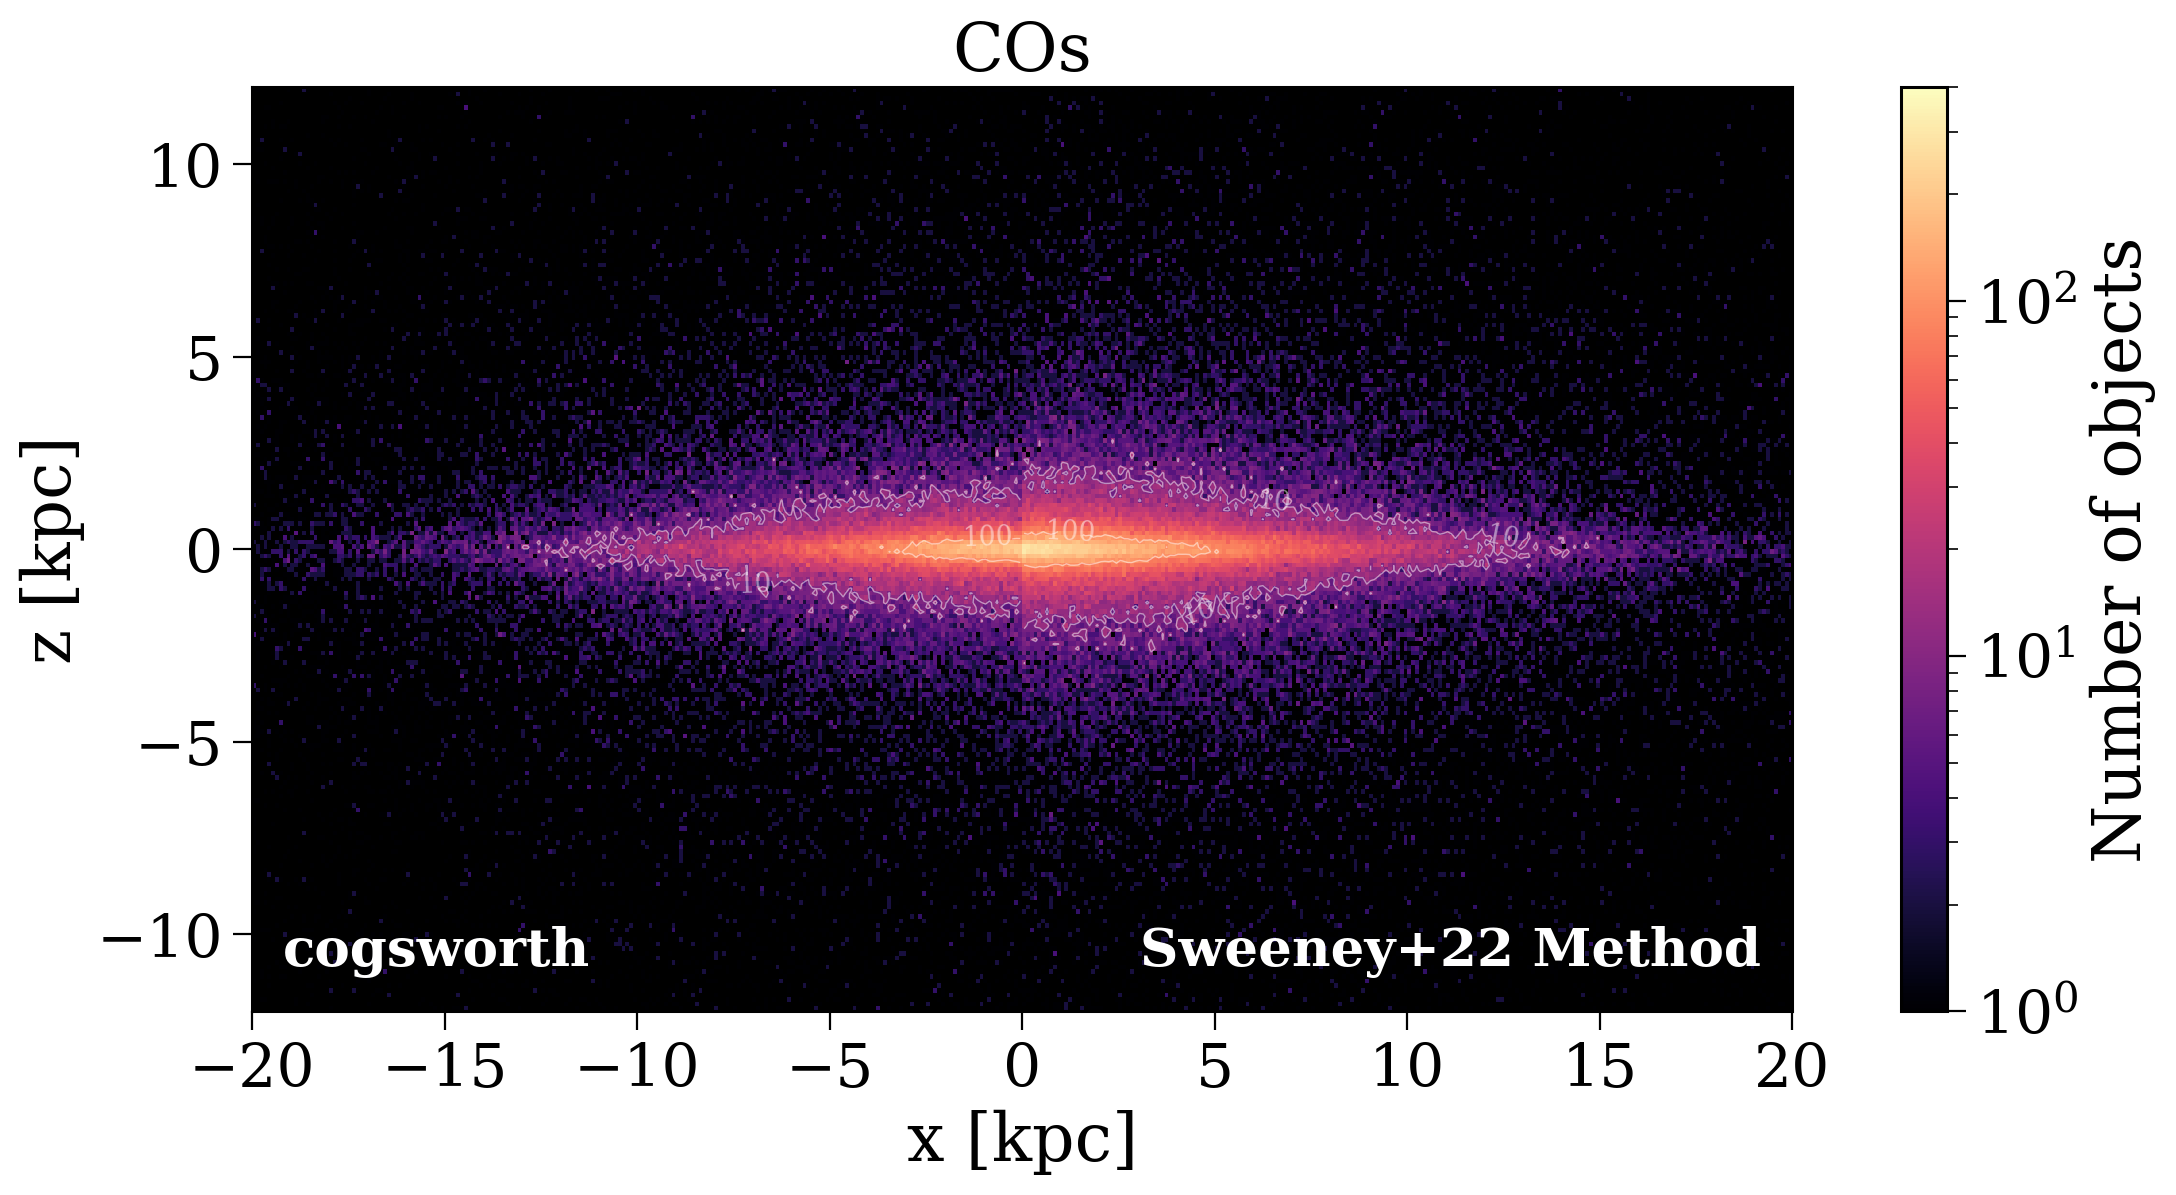

In [72]:
for co_type in ["NS", "BH", "CO"]:
    fig, ax = plotting.plot_side_on_density(
        xs=[kinematics["Binaries"]["pos"][co_type][:,0], kinematics["Sweeney"]["pos"][co_type][:,0]],
        zs=[kinematics["Binaries"]["pos"][co_type][:,2], kinematics["Sweeney"]["pos"][co_type][:,2]],
        labels=["cogsworth", "Sweeney+22 Method"],
        show=False,
        contours=[10, 100],
        apply_smoothing=False
    )
    ax.set_title(f"{co_type}s", fontsize=fs)

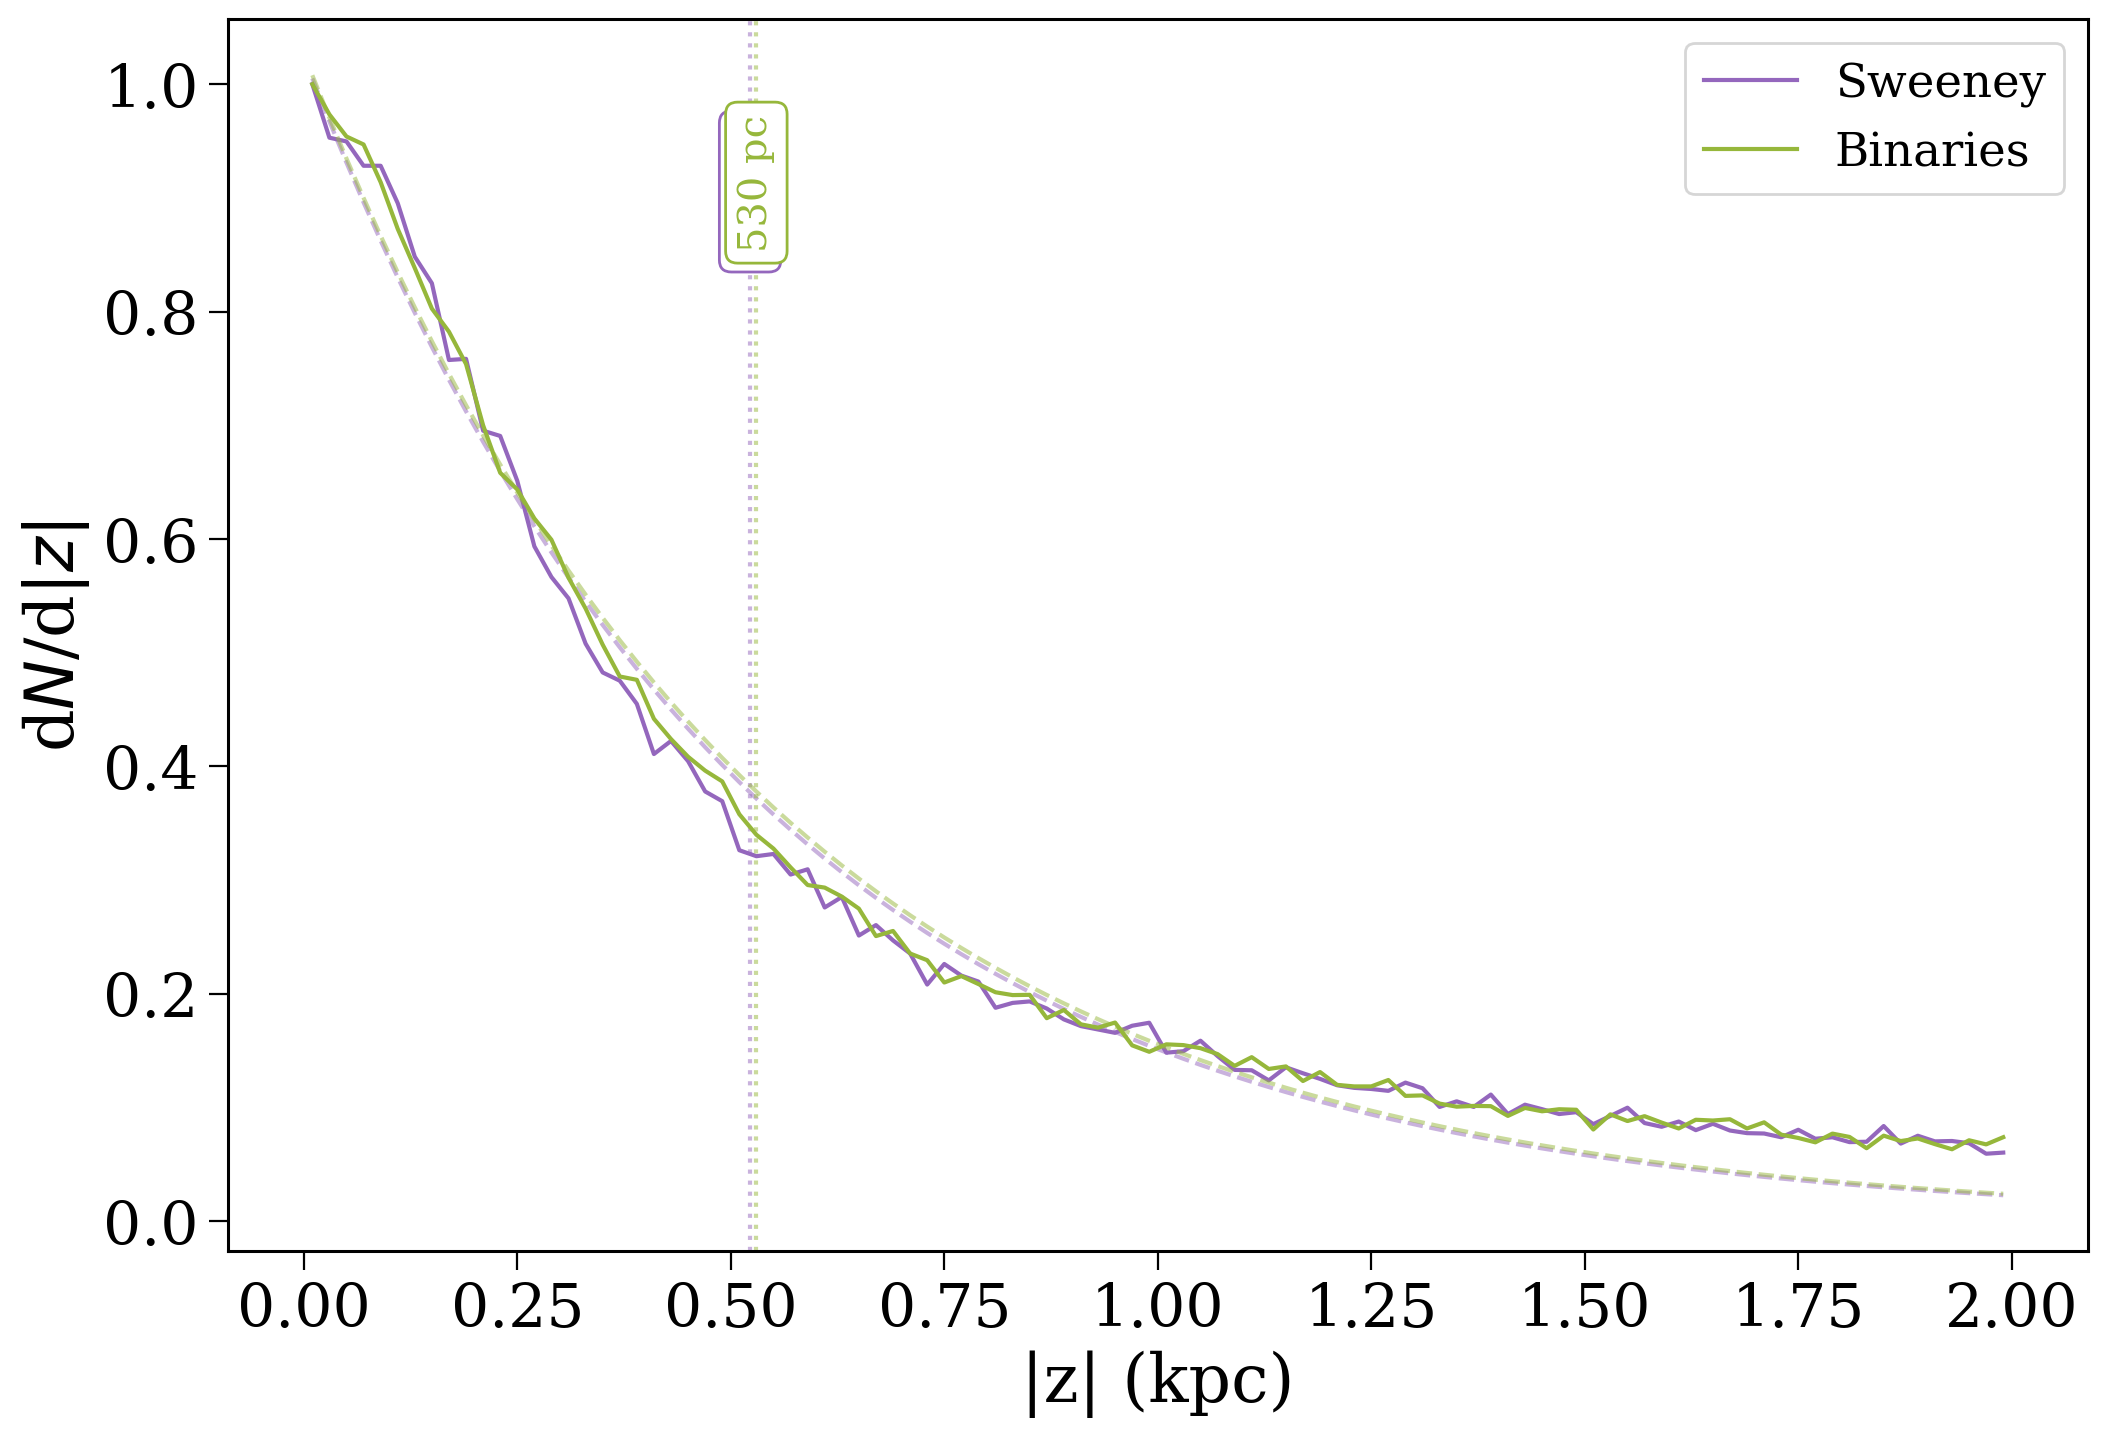

In [7]:
fig, ax = plt.subplots()

co_type = "CO"

for z, label, colour in zip(
    [kinematics["Sweeney"]["pos"][co_type][:, 2], kinematics["Binaries"]["pos"][co_type][:, 2]],
    ["Sweeney", "Binaries"],
    ["tab:purple", binaries.colour]
):
    scale_height, _, _ = plotting.estimate_scale_height(
        z=z,
        plot=True,
        label=label,
        colour=colour,
        show=False,
        fig=fig,
        ax=ax
    )

plt.show()

Inner 10 kpc
  cogsworth fraction within 0.5 kpc 0.47
  S22 Method fraction within 0.5 kpc 0.46
Full population
  cogsworth fraction within 0.5 kpc 0.37
  S22 Method fraction within 0.5 kpc 0.27


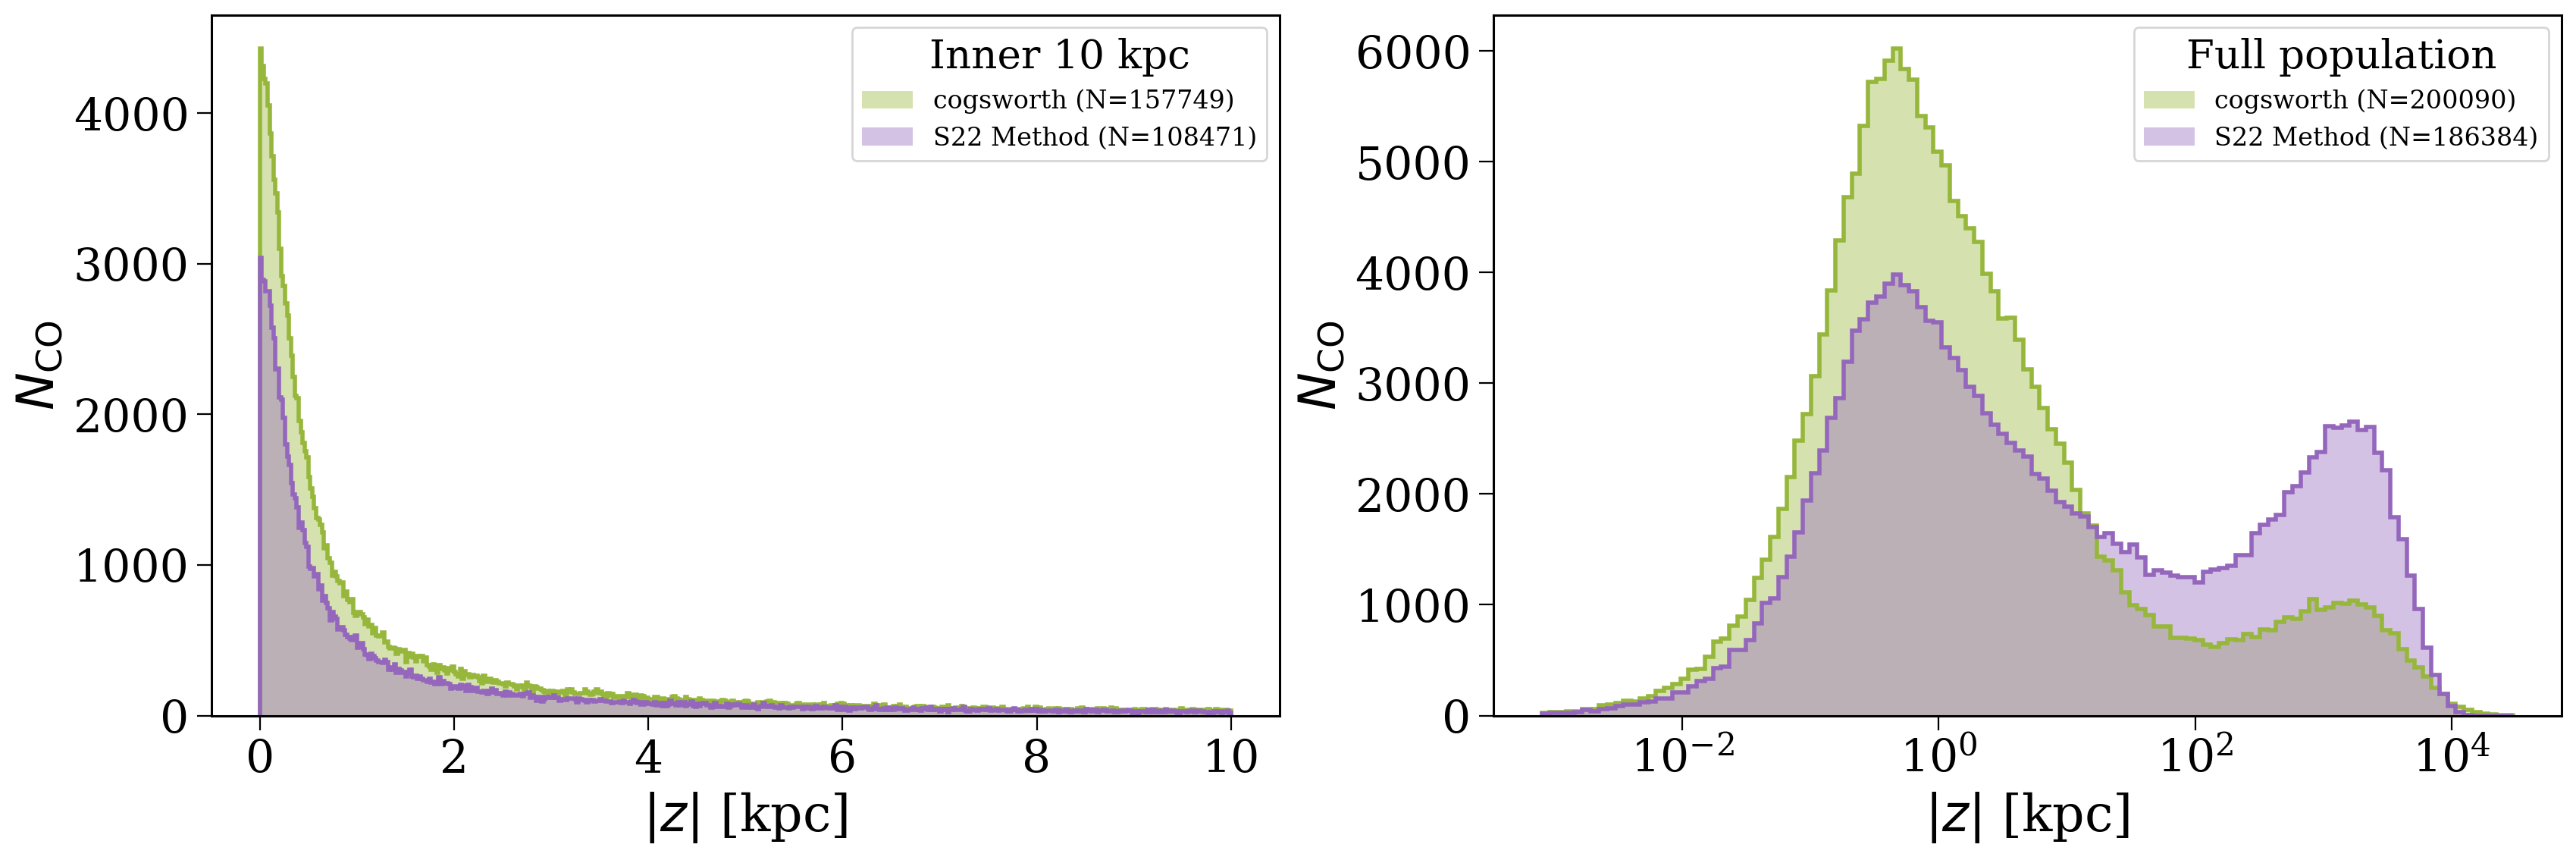

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 10, 501), np.geomspace(8e-4, 3e4, 120)]
labels = ['Inner 10 kpc', 'Full population']

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    print(label)

    colours = [binaries.colour, "tab:purple"]
    k_labels = ["cogsworth", "S22 Method"]
    for key, k_label, c in zip(kinematics, k_labels, colours):
        co_pos = kinematics[key]["pos"]["CO"]

        mask = np.abs(co_pos[:, 2].to(u.kpc).value) < bins[-1]
        print(f"  {k_label} fraction within 0.5 kpc {(abs(co_pos[:, 2].to(u.kpc).value) < 0.5).sum() / mask.sum():1.2f}")

        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, histtype='step', lw=2, color=c)
        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, alpha=0.4, color=c,
                label=f'{k_label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$|z|$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label, fontsize=0.5*fs)
plt.show()

In [9]:
# calculate the fraction that escape the galaxy in each pop
escape_fractions = {}
for label in kinematics:
    co_pos = kinematics[label]["pos"]["CO"]
    co_vel = kinematics[label]["vel"]["CO"]

    r = np.linalg.norm(co_pos.to(u.kpc).value, axis=1) * u.kpc
    v = np.linalg.norm(co_vel.to(u.km / u.s).value, axis=1) * u.km / u.s

    esc_vel = np.sqrt(-2 * binaries.galactic_potential(co_pos.T)).to(u.km / u.s)

    escaped = v > esc_vel
    escape_fractions[label] = escaped.sum() / len(escaped)

print("Escape fractions:")
for label, frac in escape_fractions.items():
    print(f'  - {label}:{(20-len(label))*" "} = {frac:1.2f}')

Escape fractions:
  - Binaries:             = 0.11
  - Sweeney:              = 0.29
